In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
mpl.rcParams['figure.figsize']=(12,10)

In [9]:
df=pd.read_csv('/home/roman/timeseries/timeseries-clustering-vae/data/ECG5000/ECG5000_TEST',header=None)
dataset=df.to_numpy()

In [11]:
dataset_x=dataset[:,1:]
dataset_y=dataset[:,0]

# Detecting Outlet

In [80]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader,Dataset
import time

In [234]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        #self.enc1 = nn.Linear(in_features=784, out_features=256)
        #self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=140, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
    def forward(self,x):
        # encoding
        #x = F.relu(self.enc1(x))
        #x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        self.dec1 = nn.Linear(in_features=32, out_features=64)
        self.dec2 = nn.Linear(in_features=64, out_features=140)
        #self.dec3 = nn.Linear(in_features=128, out_features=256)
        #self.dec4 = nn.Linear(in_features=256, out_features=784)

    def forward(self,x):
         
        # decoding
        x = torch.sigmoid(self.dec1(x))
        x = torch.sigmoid(self.dec2(x))
        #x = torch.sigmoid(self.dec3(x))
        #x = torch.sigmoid(self.dec4(x))
        return x

class SparceAutoencoder(nn.Module):
    def __init__(self,learning_rate=0.001,sparce_weight=0.001):
        super(SparceAutoencoder,self).__init__()
        
        self.encoder=Encoder()
        self.decoder=Decoder()
        self.criterion = nn.MSELoss()
        # the optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        # list of layers
        self.model_children = list(list(self.children())[0].children()) + \
                            list(list(self.children())[1].children())
        self.sparce_weight=sparce_weight
        self.device=get_device()
        self.verbose=False

    def forward(self,x):

        x=self.encoder(x)
        x=self.decoder(x)
        return x

    def sparse_loss(self, x):
        loss = 0
        values = x
        for i in range(len(self.model_children)):
            self.i2=i
            values = F.relu((self.model_children[i](values)))
            loss += torch.mean(torch.abs(values))
        return loss
    
    def fit_epoch(self, dataloader, epoch,add_sparsity='yes'):
        if self.verbose:
            print('Training')
        self.train()
        running_loss = 0.0
        counter = 0
        for i, data in tqdm(enumerate(dataloader), total=len(dataloader),disable=True):
            counter += 1
            value, _ = data
            value = value.to(self.device)

            value = value.view(value.size(0), -1)
            self.s1=value
            self.optimizer.zero_grad()
            outputs = self(value)
            mse_loss = self.criterion(outputs, value)
            if add_sparsity == 'yes':
                l1_loss = self.sparse_loss( value)
                # add the sparsity penalty
                loss = mse_loss + self.sparce_weight * l1_loss
            else:
                loss = mse_loss
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / counter
        if self.verbose:
            print(f"Train Loss: {loss:.3f}")
        return epoch_loss

    def fit(self,trainloader,testloader,epochs):
        self.train_loss = []
        self.val_loss = []
        start = time.time()
        for epoch in tqdm(range(epochs),total=epochs):
            if self.verbose:
                print(f"Epoch {epoch+1} of {epochs}")
            train_epoch_loss = self.fit_epoch(trainloader, epoch)
            val_epoch_loss = self.validate(testloader, epoch)
            self.train_loss.append(train_epoch_loss)
            self.val_loss.append(val_epoch_loss)
        end = time.time()

    def reconstruct(self, data):
        self.eval()
        value, _ = data
        with torch.no_grad():
            value = value.to(self.device)
            value = value.view(value.size(0), -1)

            output = self(value)
        return output

    def latent(self, data):
        self.eval()
        value, _ = data
        with torch.no_grad():
            value = value.to(self.device)
            value = value.view(value.size(0), -1)

            output = self.encoder(value)
        return output
        
    def validate(self, dataloader, epoch):
        if self.verbose:
            print('Validating')
        self.eval()
        running_loss = 0.0
        counter = 0
        with torch.no_grad():
            for i, data in tqdm(enumerate(dataloader), total=len(dataloader),disable=True):
                counter += 1
                self.k1=data
                value, _ = data
                value = value.to(self.device)
                value = value.view(value.size(0), -1)
                outputs = self(value)
                loss = self.criterion(outputs, value)
                running_loss += loss.item()
        epoch_loss = running_loss / counter
        if self.verbose:
            print(f"Val Loss: {loss:.3f}")  
        
        
        return epoch_loss
        

# Make dataset

In [225]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# dataset class
class VecDataset(TensorDataset):
  
    def __init__(self, X, y,split=1,batch=32):
        super(VecDataset).__init__()
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        
        self.X = torch.Tensor(X)
        self.y = torch.from_numpy(y).float()
        self.X_train,self.X_test,self.y_train,self.y_test = \
            train_test_split(X,y,train_size=split,shuffle=True,random_state=1)

        self.X_train_norm=torch.Tensor(self.scaler.fit_transform(self.X_train))
        self.y_train=torch.from_numpy(self.y_train).float()
        self.X_test_norm=torch.Tensor(self.scaler.transform(self.X_test))
        self.y_test=torch.from_numpy(self.y_test).float()

        self.train=TensorDataset(self.X_train_norm,self.y_train)
        self.test=TensorDataset(self.X_test_norm,self.y_test)

        self.split=split
        self.batch=batch
        #self.train,self.test = self.train_test_split(self.split)
        self.trainloader=self.loader(self.train,self.batch,shuffle=True)
        self.testloader=self.loader(self.test,self.batch)

    def train_test_split(self,split_param):
        #not used
        train_size = int(0.8 * len(self))
        test_size = len(self) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(self, [train_size, test_size]) 
        return train_dataset,test_dataset

    def __len__(self):
        return self.X.shape[0]
  
    def __getitem__(self, index):
        return (self.X[index], self.y[index])
    
    def loader(self,dataset,batch=32,shuffle=True):
        return DataLoader(dataset,batch_size=batch,shuffle=True)

In [235]:
data=VecDataset(dataset_x,dataset_y,split=0.8,batch=32)

In [254]:
res=[]
model={}
for i in [0.001,0.005,0.0005]: #0.01,
    model[i]=SparceAutoencoder(learning_rate=0.0001,sparce_weight=i)
    model[i].fit(data.trainloader,data.testloader,epochs=640)
    res.append(model[i].train_loss[-1])
    print('lr=',i,' loss=',model[i].train_loss[-1],' val_loss=',model[i].val_loss[-1])
    #models.append(model1)
    

100%|██████████| 640/640 [03:11<00:00,  3.35it/s]


lr= 0.001  loss= 0.0007072488323525748  val_loss= 0.0006126301224616453


100%|██████████| 640/640 [03:12<00:00,  3.32it/s]

lr= 0.005  loss= 0.004958907232941252  val_loss= 0.005205402608382805


<AxesSubplot:>

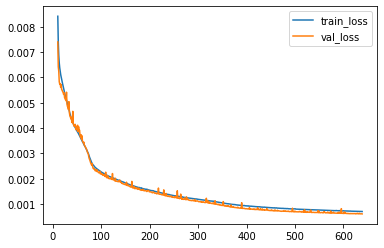

In [267]:
pd.DataFrame({'train_loss':model[0.001].train_loss,'val_loss':model[0.001].val_loss})[10:].plot()

In [376]:
r=model[0.001].reconstruct((data.train[:][0],data.train[:][1]))

In [385]:
data.train[:][0].shape

torch.Size([3600, 140])

<AxesSubplot:>

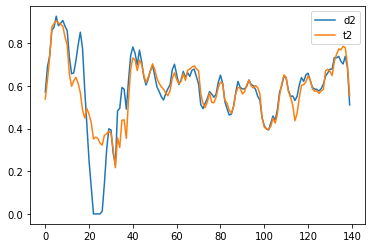

In [381]:
sd=pd.DataFrame()
sd['t1']=r[2]
sd['t2']=r[12]
sd['t3']=r[4]
sd['d1']=data.test[2][0]
sd['d2']=data.train[12][0]
sd['a2']=sd['d1'].cumsum()
sd[['d2','t2']].plot()

<AxesSubplot:>

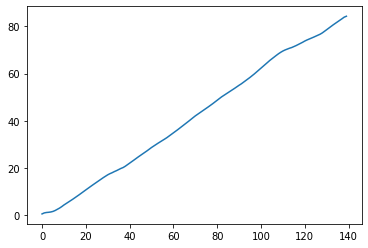

In [299]:
sd['a2'].plot()

# loss analisys

In [377]:
loss=[]
for i in range(len(data.train)):
    loss.append(model[0.001].criterion(r[i],data.train[i][0]).numpy())

In [380]:
loss_arr=np.stack(loss)
print(np.where(loss_arr>0.005))

(array([  12,   17,  246,  477,  534,  680,  683,  701,  722,  858,  977,
        983,  996, 1003, 1011, 1074, 1097, 1214, 1239, 1257, 1310, 1424,
       1539, 1597, 1610, 1615, 1650, 1676, 1696, 1790, 1937, 2077, 2081,
       2311, 2320, 2396, 2496, 2564, 2690, 2879, 3086, 3169, 3199, 3224,
       3268, 3316]),)


In [383]:
dataset_x[0].shape

(140,)

<AxesSubplot:>

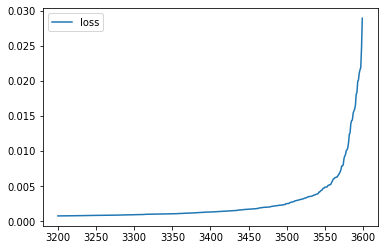

In [379]:
pd.DataFrame(loss,columns=['loss']).sort_values('loss').reset_index(drop=True)[3200:].plot()

# Augmentation

In [301]:
data.test[:][0].numpy().shape

(900, 140)

In [373]:
import utils.augmentation as aug

def ts_aug_each(a):
    #( seq len,)
    res=[]
    res2=[]
    
    b=np.cumsum(a)
    x=np.expand_dims(b,(0,2))
    x=aug.jitter(x,sigma=0.03)
    #x=np.expand_dims(x,1)
    x=aug.scaling(x,sigma=0.02)
    #x=np.expand_dims(x,0)
    x=aug.magnitude_warp(x,sigma=0.02)
    #x=np.expand_dims(x,0)
    x=aug.time_warp(x,sigma=0.015,knot=2)
    #x=np.expand_dims(x,0)
    x=aug.window_slice(x,reduce_ratio=0.99)[0]
    #x=np.expand_dims(x,0)
    #x=aug.window_warp(x,window_ratio=0.02, scales=[0.3, 0.3])[0]
    res=np.diff(x,axis=0)
    res=res.squeeze(1)
    return res

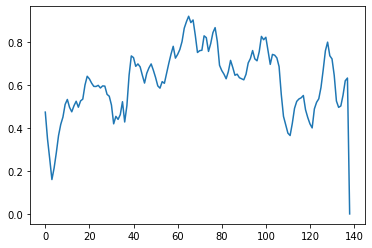

In [368]:
aug_r=ts_aug_each(data.test[32][0].numpy())
plt.plot(aug_r)

In [354]:
aug_r.shape

(139,)

<AxesSubplot:>

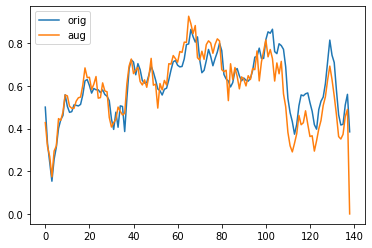

In [374]:
aug_r=ts_aug_each(data.test[32][0].numpy())
test=pd.DataFrame()
test['orig']=data.test[32][0].numpy()[1:]
test['aug']=aug_r

test.plot()

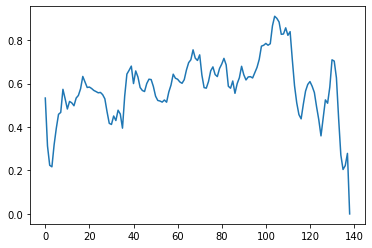

In [356]:
plt.plot(aug_r)

In [305]:
aug_r.shape

(140, 1)

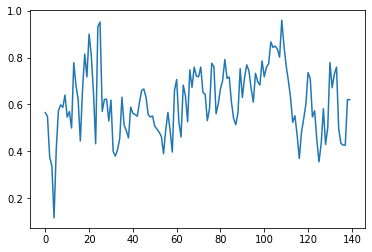

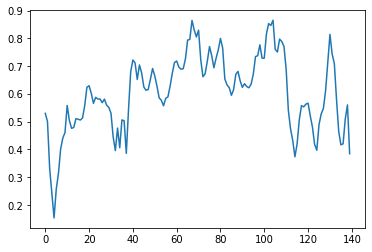

In [309]:
plt.plot(data.test[32][0].numpy())

In [389]:
def augment_ds(x,y,model):
    for i in range(x.shape[0]):
        x1=x[i]
        x1=np.expand_dims(x1,0)
        x1=torch.Tensor(x1)
        r=model.reconstruct((x1,torch.from_numpy(y[i])))
        loss=model.criterion(r,x1).numpy()
        if loss>0.005:
            print(i)
            break
        

In [408]:
scaler2=MinMaxScaler(feature_range=(0, 1))
scaler2.fit(dataset_x)
y=dataset_y
res_ds=[]
res_ds_y=[]
for i in range(x.shape[0]):
        # проработать мастабирование оно не нужно на выходе и нужно при подаче в модель
        #причем при подаче в модель лучше масштабирование из дата
        x1=x[i]
        x1=np.expand_dims(x1,0)
        x1=torch.Tensor(x1)
        res_ds.append(x1.numpy()[0,1:])
        res_ds_y.append(y[i])
        r=model[0.001].reconstruct((x1,torch.Tensor(np.expand_dims(y[i],0))))
        loss=model[0.001].criterion(r,x1).numpy()
        if loss>0.005:
            print(i)
            for j in range(20):
              res_ds.append(ts_aug_each(x1.numpy()))
              res_ds_y.append(y[i])
        else:
            for j in range(4):
              res_ds.append(ts_aug_each(x1.numpy()))
              res_ds_y.append(y[i])        

178
852
890
1118
1142
1179
1293
1370
1660
1917
2148
2248
2314
2443
2591
2608
2662
2686
2708
2709
2711
2712
2715
2716
2751
2815
2831
2890
2892
2929
2930
2932
2935
2936
3003
3174
3250
3323
3327
3346
3347
3348
3354
3355
3356
3404
3412
3413
3415
3416
3417
3421
3424
3483
4335
4366
4382
4383
4384


In [409]:
ds_x=np.stack(res_ds)
ds_y=np.stack(res_ds_y)


In [410]:
ds_x.shape

(23444, 139)

In [411]:
data2=VecDataset(ds_x,ds_y,split=0.8,batch=64)

In [412]:
model2=SparceAutoencoder(learning_rate=0.0001,sparce_weight=0.001)
model2.fit(data2.trainloader,data2.testloader,epochs=640)

  0%|          | 0/640 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x139 and 140x64)

In [413]:
data2.test[:][0].numpy().shape

(4689, 139)